## K-Nearest Neighbors

In this assignment we explore the KNN algorithm on data from the Dram Shop. This repo contains two files for you to apply KNN to. The file `knn-training-data.txt` holds a specific subset of Dram customer data. The data has the following fields: 

* `customer_id`: a unique ID for the customer
* `most_popular_category`: the most popular category for the customer
* `relationship_days`: the number of days between the first and last transaction for the customer.
* `total_spend`: the lifetime total spend by the customer
* `beverage_categories`: the number of distinct beverage categories the customer has purchased from.
* `segment`: a four-level categorical variable that segments the customers.

Using the course materials and class discussion, determine a distance metric between customers. Use this metric to implement a k-nearest neighbor algorithm. You don't need to do any systematic testing of `k`, but I'd recommend picking something larger than 10 since we have four categories. 

The file `knn-testing-data.txt` holds data with the segments removed. Use your algorithm to apply segments to this data. I've included the file `testing-true-values.txt` so that you can measure your accuracy. Don't be despondent if your accuracy is low on this assignment. 


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns


from io import StringIO
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix



In [2]:
file_path = 'knn-training-data.txt'

# Open the file in read mode ('r')
with open(file_path, 'r') as file:

    # Read the lines into a list
    lines = file.readlines()

# Convert the list to a DataFrame
train_data = pd.read_csv(StringIO('\n'.join(lines)), delimiter='\t')
#train_data

In [3]:
test_file = 'knn-testing-data.txt'

# Open the file in read mode ('r')
with open(test_file, 'r') as file:

    # Read the lines into a list
    test_lines = file.readlines()

test_data = pd.read_csv(StringIO('\n'.join(test_lines)), delimiter='\t')

In [4]:
test_true_file = 'testing-true-values.txt'

# Open the file in read mode ('r')
with open(test_true_file, 'r') as file:

    # Read the lines into a list
    true_lines = file.readlines()

test_true_data = pd.read_csv(StringIO('\n'.join(true_lines)), delimiter='\t')

In [5]:
# Create a function for KNN
class KNNClassifier:
    def __init__(self, k=3):
        self.k = k

    # First create a function that will calculate the distance between obs
    def euclidean_distance(self, point1, point2):
        return np.sqrt(np.sum((point1 - point2) ** 2))

    # Then a function to fit the KNN
    # X_train are the features
    # y_train is the target
    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    # Function to predict the segment for the test data
    def predict(self, X_test):
        predictions = []
        for test_point in X_test:
            distances = [self.euclidean_distance(test_point, train_point) for train_point in self.X_train]
            k_nearest_indices = np.argsort(distances)[:self.k]
            k_nearest_labels = [self.y_train[i] for i in k_nearest_indices]
            most_common_label = np.bincount(k_nearest_labels).argmax()
            predictions.append(most_common_label)
        return predictions

In [6]:
# Extract features (X) and labels (y) for training data
X_train = train_data.drop(['customer_id', 'segment'], axis=1)
y_train = train_data['segment']

# The test data
X_test = test_data

# Convert categorical labels to numerical labels using LabelEncoder
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)

# Assuming 'most_popular_category' is a categorical variable
X_train_encoded = pd.get_dummies(X_train, columns=['most_popular_category'])

# Instantiate the KNN classifier
knn = KNNClassifier(k=25)

# Fit the model on the training data
knn.fit(X_train_encoded.values, y_train)

# Extract features for testing data and apply one-hot encoding
X_test_encoded = pd.get_dummies(test_data, columns=['most_popular_category'])

# Ensure that the testing data has the same columns as the training data
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

# Make predictions on the testing data
predictions = knn.predict(X_test_encoded.values)

# Reverse transform numerical labels to original categorical labels
predicted_labels = label_encoder.inverse_transform(predictions)

# Add a new column 'predicted_segment' to the test_data dataframe
test_data['predicted_segment'] = predicted_labels

In [7]:
merged_test = pd.merge(test_data, test_true_data, on='customer_id', how='inner')
merged_test.head(10)

,customer_id,most_popular_category,relationship_days,total_spend,beverage_categories,predicted_segment,segment
0,", 9GT0P908DS5VGJYRYG4CHAPSQG",sour,224,145.00,5,explorer,explorer
1,", D74N0TBT7D2K6YPYDA734V56Y4",seasonal,272,152.50,5,explorer,explorer
2,", XHN902RSGS7V6ZBWN7FE5QVGA4",ipa,371,55.00,3,cheapo,cheapo
3,", YDZ8kOpLlCLDlmom",softgoods,609,159.00,6,loyal core,loyal core
4,-uNXHhkiA5JEebdj,tasting/event,802,107.00,8,loyal core,loyal core
5,00GN9QQ53H639C9EW0KJRKGN5W,lagers/pils/wheat,213,92.00,2,newbie,newbie
6,00M2PX68JH0E2Y44BSXPB8WPR8,sour,590,123.00,12,loyal core,loyal core
7,00PYAN31NH58CYD297MVV2JQTC,seasonal/tasting/event,559,94.50,5,cheapo,cheapo
8,00R2NCKF4X5SCSTW59HRY5VDG8,seasonal/tasting/event,314,79.00,6,newbie,newbie
9,00ZSCPVYFH2TEMWQTV6M8PC3K0,sours,393,378.25,13,loyal core,loyal core


In [8]:
# Assuming 'segment' is the true labels in the test_data dataframe
true_segment = merged_test['segment']
predicted_segment = merged_test['predicted_segment']

# Compare true labels with predicted labels
accuracy = accuracy_score(true_segment, predicted_segment)
classification_report_str = classification_report(true_segment, predicted_segment)
confusion_mat = confusion_matrix(true_segment, predicted_segment)

print(f"Accuracy: {accuracy}")
print("\nClassification Report:\n", classification_report_str)


Accuracy: 0.9927333705980995

Classification Report:
               precision    recall  f1-score   support

      cheapo       0.98      1.00      0.99       444
    explorer       0.99      0.98      0.99       262
  loyal core       0.99      0.98      0.99       521
      newbie       1.00      1.00      1.00       562

    accuracy                           0.99      1789
   macro avg       0.99      0.99      0.99      1789
weighted avg       0.99      0.99      0.99      1789



The overall accuracy for my KNN model is 99%. This seems inflated, but I can't figure out where the glitch is. 

In writing a KNN classifier algorithm, three functions were developed, one for the euclidean distance, one for fitting the data, and one for predicting the segment for the test data. I then joined the predicted segments with the actual segments by customer ID. This allowed me to develop a confusion matrix to calculate the accuracy of my model. 

The recall for explorer was the lowest (barely), which means that it had a higher proportion of observations that were incorrectly predicted to be other segments as compared to the other segments. Cheapo had the lowest precision, which means that only 97% of the observations predicted to be cheapo were actually cheapo. 

The chart below provides a visualization of the confusion matrix for the predicted and true segments. The chart shows that the category for which cheapo was most often incorrectly predicted was loyal core. If I'm going to the same pub every week, there will definitely be weeks where I only get one $5 beer, classifying me as a cheapo for that week. 

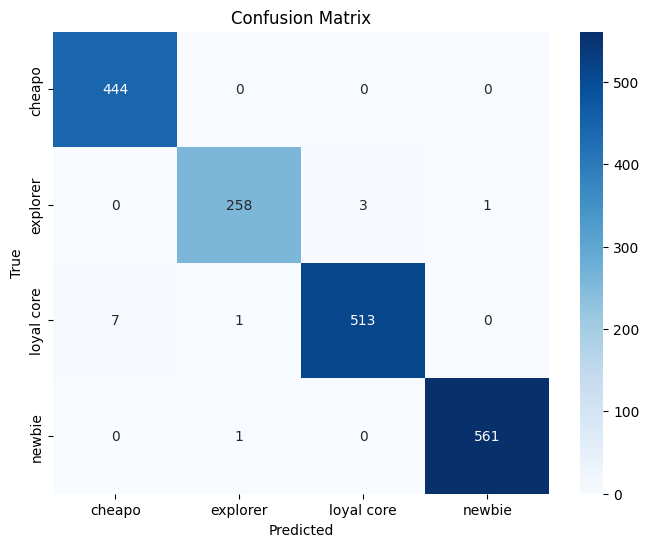

In [9]:
# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

